# Capstone: Analyzing dinucleotide usage in the Human Genome

We know that the human genome is made up of DNA that is in turn organized into chromosomes. We have seen that the 4 nucleotides present in DNA can be represented by the letters A, T, C and G, and that we can calculate the proportions of these letters in genomes. 

But what about larger patterns? For example, if a genome is 20% A, 20% T, 30% G and 30 % C, should we expect that the number of cases in which an A is followed by a T is proportional to the frequency of these letters in the genome?

If so, we could use some basic knowledge of how to combine independent probabilities by multiplication to predict how often we would get certain 2 letter combinations like "AT" or "CG". Such two letter combinations are known as **dinucleotides** (di = two).

In this section we will develop code for calculating the frequency of a particular dinucleotide, test it on some example sequences to make sure it works, and then hook that code up to the FASTA file parser we previously developed in order to run it over an entire genome.

This will let us test the hypothesis that CG dinucleotides are formed more or less randomly based on when C nucleotides happen to be next to G nucleotides.

Here's a summary of what we're trying to do:

#### Goal: Calculate 'CG' dinucleotide frequency in many genomes

1. Calculate dinucleotide frequency in a DNA sequence
    - a. Define a test example
    - b. Determined the right answer on that test example by hand
    - c. Write code to get that correct answer given a sequence
    - d. Test is with multiple examples where we know the right answer
2. Download a genome in FASTA format   
3. Parse a FASTA file for a genome
4. Loop over all the sequences in that FASTA file
5. Calculate an observed and expected dinucleotide frequency for each gene
6. Plot the observed results against the expected results to test our hypothesis.

## Calculating Dinucleotide Frequency from a Sequence in Python

There are at least two ways to calculate dinucleotide frequency: 

**overlapping dinucleotides** count a dinucleotide starting at each index except the last one. So for example, the above sequence "GCTACGTACG" would form overlapping dinucleotides "GC","CT","TA","AC", etc.

**non-overlapping dinucleotides** count the first dinucleotide, then count the next as starting where the previous one ended. In the sequence "GCTACGTACG", this would result in non-overlapping dinucleotides "GC","TA","CG","TA","CG". Notably, the number of non-overlapping dinucleotides depends on whether the length of the sequence is odd or even. If it's odd (e.g. "GCA"), the last letter (e.g. "A") is ignored, resulting in 2 fewer dinucleotides than the total length of the sequence (there's only one non-overlapping dinucleotide — "GC" —  in the 3 letter sequence "GCA")

**3-1 dinucleotides** 3-1 dinucleotides pertain to *protein coding sequences*. Recall that protein coding sequences are arranged into 3 letter codons, each of which codes for an amino acid (or e.g. a stop codon indicating the end of the amino acid chain). 3-1 dinucleotides include the last position of one codon and the first position of the next. Why these two positions specifically? Not all codon positions have equal influence on the final amino acid. For many — but not all—  amino acids the 3rd codon position doesn't matter at all. For instance, in the "standard" translation table, TCA, TCT,TCC and TCG all encode Serine. On average, the second codon position has the strongest influence on which amino acid is selected — TCA is Serine but TGG is Tryptophan for instance — the 3rd codon position has the least average influence, and the 1st codon position is intermediate. Therefore, 3-1 dinucleotides reflect dinucleotides that minimally influence of the encoded amino acid. That is useful if you want to study e.g. mutational processes rather than natural selection acting on the protein encoded by the amino acid. If the example sequence up above can be assumed to be 'in frame' with the first letter being the first position of the first codon, then it would include 3-1 dinucleotides: "TA" (the dinucleotide joining the codon "GCT" to "ACG")

In [56]:
expected_cgs = 2
expected_dinucs_total = 9
expected_cg_freq = expected_cgs/expected_dinucs_total
print(expected_cg_freq)

0.2222222222222222


Based on this preliminary work, we can define our own function to calculate CG content:

In [57]:
def calculate_cg_content(sequence):
    """Return the CG content of a sequence as a float
    sequence -- a string representing a DNA sequence
    """
    #Make sure sequence is uppercase
    sequence = sequence.upper()
    cg_dinucs = sequence.count("CG")
    total_dinucs = len(sequence) 
    cg_freq = cg_dinucs/total_dinucs 
    return cg_freq

In [58]:
print(calculate_cg_content)

<function calculate_cg_content at 0x113ef8d08>


In [59]:
observed_cg_content = calculate_cg_content(test_sequence)
print(observed_cg_content)

0.2




There are several catches to be aware of when calculating dinucleotide content:
    
- CG dinucleotide content is not the same as G+C content. For example, the sequence 'GCAGC' has 80% GC content but 0% CG dinucleotide content

- The tricky part to calculating CG content is figuring out whether one wants to calculate 'overlapping' or 'non-overlapping' dinucleotide content, and based on that to determine the total dinucleotides in a sequence. In our case, let's calculate 'overlapping' dinucleotide content. This means that the sequence 'GCTA' is turned into overlapping dinucleotides ['GC','CT','TA']. If instead we were calculating 'non-overlapping' dinucleotide content, the same 'GCTA' sequence would be turned into non-overlapping nucleotides ['GC','TA']. 

- In the overlapping case, the total number of dinucleotides is easy to establish: it is just one less than the length of the sequence. For example, the sequence 'A' has 0 overlapping dinucleotides, 'AT' has 1, 'ATC' has 2 ('AT' and 'TC), etc. 

- If we're calculating non-overlapping dinucleotides, we have to pay attention to whether the sequence length is divisible by 2 or not: the sequence 'A' has 0 non-overlapping dinucleotides, 'AT' has 1, but 'ATC' still only has 1 ('AT'), 'ATCG' has 2, 'ATCGC' has 2 again, etc. This can be represented by the sequence length -1 if the sequence length is divisible by 2, or the sequence length -2 if it isn't divisible by 2.

#### Calculating Expected CG content

If there was no special biology governing CG dinucleotides, how many of them should we expect in any given sequence?

We can formulate this question as a hypothesis: 
>**Hypothesis:** C and G are independent. Therefore the chances of getting a G right after a C are purely based on the frequency of G

From basic probability, recall that the chances of two independent random events occuring together is just the product of their individual probabilities. So we understand that if G's have a frequency of, say, 20% in the overall genome, and Cs have a frequency of 20%, then the frequency of CG dinucleotides we expect *if* our hypothesis is correct, is 0.20 x 0.20 = 0.04, or 4% of total dinucleotides.  More generally, if this hypothesis is correct, the frequency of CG dinucleotides can be written as a formula in terms of the frequency of C nucleotides and G nucleotides:

$$ f(CG) = f(C) * f(G) $$

Here f(something) should be read as 'the frequency of ' whatever is in parentheses. So we would read this as: the frequency of CG dinucleotides is equal to the frequency of C nucleotides times the frequency of G nucleotides. 
Let us emphasize again that this equation is *only* true *if* C and G occur independently. So this is a very simple concept, but we now have a compact way to describe it mathematically.

Another way to describe this same idea is to say that — under our hypothesis — the chances of getting a G don't depend on whether you have a C beforehand. Mathematically this can be written as follows:

$$ f(G|C) = f(G) $$

The bar | should be read as 'given' or 'conditional on'. So the whole equation can be read as "the frequency of getting a G given that you just had a C is the same as the overal frequency of G". If we wanted to, we could assert the same thing for all other preceding nucleotides:

$$ f(G|A) = f(G) $$
$$ f(G|T) = f(G) $$
$$ f(G|C) = f(G) $$
$$ f(G|G) = f(G) $$

In other words, according to our hypothesis the previous letter doesn't matter.

It is critical to note that all of these summaries are just predictions, based on our hypothesis. Writing them as equations doesn't make them true. Indeed, you can write all sorts of mathematically valid equations that do not in fact describe anything at all about biology. So our next task is to test the predictions of our hypothesis using biological data. 

Our equations outline a simple way to do so. We already have code to calculate the actual observed frequency of CG dinucleotides in a sequence. We also have an equation saying what frequency of CG dinucleotides we should expect under our hypothesis given the frequency of the letters C and G in our sequence.

In [60]:
#### Calculating expected CG content

def calculate_expected_cg_content(sequence):
    """Return the expected CG content of a sequence as a float
    sequence -- a string representing a DNA sequence
    
    The expected CG content is calculated
    under the assumption that C and G nucleotides 
    occur independently. If that were true,
    then the frequency of CG dinucleotides would
    just be the frequency of G nucleotides times
    the frequency of C nucleotides.
    """
    #Need to ensure sequence is uppercase
    sequence = sequence.upper()
    freq_g = sequence.count("G")/len(sequence)
    freq_c = sequence.count("C")/len(sequence)
    
    freq_cg = freq_g * freq_c 
    return freq_cg

## Download all (predicted) coding sequences from the Human Genome

The National Center for Biotechnology Information (NCBI) website has an ftp server with
a wide variety of genomes. The codig sequences for the human genome can be found here:

https://ftp.ncbi.nih.gov/genomes/refseq/vertebrate_mammalian/Homo_sapiens/annotation_releases/109.20210226/GCF_000001405.39_GRCh38.p13/

We want to pick this file:

`GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna.gz`

The key points to recognize are the `cds` stands for coding sequences — the parts of the genome that code for proteins, `fna` indicates nucleotide data in FASTA format, and `.gz` indicates that the results will be compressed with `gzip`, so you have to expand them before working with them in python (depending on your system this might require installing software for decompressing gzip files)

Once we've extracted the file, we should ensure we have a file with the name './GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna' in our current working directory.

We can test this by trying to open it in python:

In [61]:
human_genome_filepath = './GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna'
human_genome_file = open(human_genome_filepath)
human_genome_file.close()

>STOP HERE and download the human genome from the link above ... later steps won't work unless you have it present in the same directory as you are running your code from. 

#### Incorporating our FASTA parser

In a previous section, we developed a simple FASTA file parser that returned a dictionary linking each sequence id in a FASTA file to it's sequence.

We can now use this in combination with our code for counting the observed and actual frequency of "CG" dinucleotides.

As a reminder, here is our FASTA parser:


In [62]:
def parse_fasta_file(input_file):
    """Return a dict of {id:gene_seq} pairs based on the sequences in the input FASTA file
    input_file -- a file handle for an input fasta file
    """
    parsed_seqs = {}
    curr_seq_id = None
    curr_seq = []

    for line in f:
        line = line.strip()

        if line.startswith(">"):
            if curr_seq_id is not None:
                parsed_seqs[curr_seq_id] = ''.join(curr_seq)

            curr_seq_id = line[1:]
            curr_seq = []
            continue

        curr_seq.append(line)

    #Add the final sequence to the dict
    parsed_seqs[curr_seq_id] = ''.join(curr_seq)
    return parsed_seqs




#### Testing the FASTA parser on a genome:

Let's make sure we can run our parser the whole human genome.

In [63]:
#Normally this would be determined
#by user input via argparse. Hard-coded for now

input_file = human_genome_filepath

f = open(input_file)
parsed_seqs = parse_fasta_file(input_file)
print("Done parsing genome")

Done parsing genome


We don't want to print all the parsed sequences to screen at once, as it would be too much text to look at. Instead, let's loop over the first few of them.

How can we iterate over parsed_seqs?  First, let's note that parsed seqs is a `dict` object. We can tell this because in the code for our FASTA parser up above it was defined with curley braces {}. We could also call the `type` function on `parsed_seqs` to verify this if we were unsure:

In [64]:
type(parsed_seqs)

dict

 Given this information, what we want to do can be stated in general terms as: we have a dictionary, and we want to iterate over all it's key-value pairs. Let's examine that general coding task, and then apply what we learn to loop our code for calculating CG dinucleotide content over a whole freakin' genome.  

#### **Python Coding Technique**: Looping over all the keys and items in a dictionary.

 Python dictionaries have an `.items()` method that returns key-value pairs from the dictionary in an arbitrary order. Let's show how this works on a simple example dictionary, then apply it to our giant dictionary of gene ids and sequences:

In [65]:
animal_adjectives = {"bears":"big","cheetahs":"fast","crows":"smart","parrots":"very freaking loud sometimes"}
print("Animal adjectives is a :",type(animal_adjectives))
print("It consists of the following key-value pairs:",animal_adjectives.items())

Animal adjectives is a : <class 'dict'>
It consists of the following key-value pairs: dict_items([('bears', 'big'), ('cheetahs', 'fast'), ('crows', 'smart'), ('parrots', 'very freaking loud sometimes')])


We've defined a dictionary (`dict`) where animals are the keys and the values are adjectives that some people might associate with them. Feel free to adjust the adjectives to whatever you associate with these animals. Calling the `.items()` method on our `dict` of animal adjectives got us a dict_items object that has within it what looks like a list. It is common to use dict_items objects like this one to iterate over dictionaries in a for loop. This can be done as follows:

In [66]:
for animal, adjective in animal_adjectives.items():
    print(f"I think of {animal} as {adjective}")


I think of bears as big
I think of cheetahs as fast
I think of crows as smart
I think of parrots as very freaking loud sometimes


#### Looping over a whole genome!

Now let's apply this to our sequences. To prevent our entire screen from filling with gene ids, I'll add an if statement that uses the `break` keyword to immediately end our loop after a certain numbers of entries. This will let us print the first 100 gene ids:

In [67]:
printed_gene_ids = 0
n_gene_ids_to_print = 100

for gene_id, sequence in parsed_seqs.items():
    
    print(gene_id)
    print(sequence)
    printed_gene_ids +=1
    if printed_gene_ids >= n_gene_ids_to_print:
        break
    
    

lcl|NC_000001.11_cds_NP_001005484.2_1 [gene=OR4F5] [db_xref=CCDS:CCDS30547.1,Ensembl:ENSP00000493376.2,GeneID:79501] [protein=olfactory receptor 4F5] [protein_id=NP_001005484.2] [location=join(65565..65573,69037..70008)] [gbkey=CDS]
ATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGC

#### Calculating observed and expected CG dinucleotide frequencies for all the genes in a genome

Now we want to run our code that we developed earlier in this notebook to calculate observed and expected frequencies of CG dinucleotides on a real genome. We'll need to keep track of which genes had which observed and expected CG contents. A natural way to do that is to have two more dictionaries, each keyed by gene id. So from our current dictionary that maps each gene id to one sequence, we will basically be building additional dictionaries that map each gene id to it's expected number of CG dinucleotides and its actual number of CG dinucleotides.

In [68]:
#Normally this would be determined
#by user input from argparse.
#It's 'hard-coded' for now.
#Replace with a path
#to a genome file on your computer
input_file = human_genome_filepath

print(f"Parsing genome at path: {input_file}")
f = open(input_file)
parsed_seqs = parse_fasta_file(input_file)
print("Done parsing genome")

#Set up dicts to hold our
#expected and observed results.

expected_cg_freqs = {}
observed_cg_freqs = {}

#NOTE: Let's use the plural "freqs" for the 
#dict of all the frequencies (as shown above),
#and the singular "freq" when referring to the
#frequency of CGs in a single sequence


print("Calculating CG dinucleotide frequency...")
#Loop over all the genes in a genome
for gene_id, sequence in parsed_seqs.items():
    
    #Run our functions to calculate the frequency
    #of observed and expected CGs for this specific sequence
    observed_cg_freq = calculate_cg_content(sequence)
    expected_cg_freq = calculate_expected_cg_content(sequence)
    
    #Save the results in dictionaries for later use
    expected_cg_freqs[gene_id] = expected_cg_freq
    observed_cg_freqs[gene_id] = observed_cg_freq

total_genes = len(observed_cg_freqs)
print(f"Done calculating CG dinucleotide frequency for {total_genes} ...")

Parsing genome at path: ./GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna
Done parsing genome
Calculating CG dinucleotide frequency...
Done calculating CG dinucleotide frequency for 124038 ...


#### Testing our hypothesis with the data

Good hypotheses make good predictions. If our hypothesis makes predictions that are very different from what we observe in biology, it's likely that our hypothesis is wrong. We can informally test how well our prediction works by plotting the predicited outcomes under our hypothesis (i.e. the `expected_cg_freq` for each gene) against our actual observations (the `observed_cg_freq` for each gene). If the two match well, this should roughly form a  straight line, with higher predictions corresponding to higher observations.

To do this, we need to iterate over one of our dicts — let's say the dict of expected CG frequencies — and compare it against the other. Critically, both dicts are keyed by exactly the same set of gene ids, so we can safely look up any gene id in the expected dict in the observed dict as well.

In [69]:
expected_values = [] #Let's build a list of expected CG dinucleotide frequency values
observed_values = [] #...and a list of expected CG dinucleotide frequency values in the same order

#Critically both sets of values must be in the same order,
#We can use a for loop to look up the observed value that 
#corresponds with each expected value, using the gene id
#to connect our two dicts of results, like this:

for gene_id, expected_cg_freq in expected_cg_freqs.items():
    
    #look up the observed value in the other dictionary
    observed_cg_freq = observed_cg_freqs[gene_id]    
    expected_values.append(expected_cg_freq)
    observed_values.append(observed_cg_freq)
    

#### Check our results

Before we go on to plot our results, let's examine the observed and expected values. This kind of checking is very important to catch mistakes before proceding. For example, the first time I wrote this code, I assumed that the sequences I would be sending to the functions for calculating CG frequencies were in uppercase. But the actual genome I used was lowercase. Since the count of "G" in a sequence "ggggg" is 0 (python distinguishes upper and lowercase letters), this resulted in observed and expected values of 0.0 for all genes! Checking your data for reasonableness as each step, and testing using hand-calculated examples where you are 100% certain of the right answer both really help ensure your code is giving you the results you expect. 

For now, let's print some example results and look at them:

In [70]:
n_examples = 10
example_expected_values = expected_values[0:n_examples]
example_observed_values = observed_values[0:n_examples]
print(f"Example observed CG dinucleotide frequencies: {example_observed_values}")
print(f"Example expected CG dinucleotide frequencies: {example_expected_values}")

Example observed CG dinucleotide frequencies: [0.013251783893985729, 0.034858387799564274, 0.027944111776447105, 0.008519701810436636, 0.07634265423879272, 0.008519701810436636, 0.008519701810436636, 0.008519701810436636, 0.008519701810436636, 0.008519701810436636]
Example expected CG dinucleotide frequencies: [0.04501429297321899, 0.07415951129907301, 0.07527460049959961, 0.05214801507506343, 0.11715976074904517, 0.05214801507506343, 0.05214801507506343, 0.05214801507506343, 0.05214801507506343, 0.05214801507506343]


To me, these results look fairly reasonable, at least at first glance. All are between 0.0 and 1.0 as we expect, no numbers obviously repeat, not all scores are 0.0 (as would happen if we forgot to convert our sequences to uppercase and therefore accidentally didn't count 'c' as 'C'!) Now let's build a graph to really see how our observations line up with the predictions of our hypothesis.

## Building a simple scatter plot in matplotlib

Matplotlib is an older python library for generating graphs. We'll talk much more about different systems for data visualization and communication in the chapter on Data Visualization. For now, it's worth knowing how to make a simple scatterplot when you need one. 

We'll base our example on a [scatterplot tutorial](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html) from the [matplotlib gallery](https://matplotlib.org/2.0.2/gallery.html). This gallery shows many example plots, and let's you click on each to get the code that produced it. You can explore some for yourself - just be aware that typically a lot of the code actually isn't graphing code at all - it's code to generate the data that they will plot. So usually the code you want to plot your data is much shorter and simpler than it may at first appear.

[matplotlib](https://matplotlib.org/) is an example of a python library that comes with the Anaconda python distribution, but not basic python. The good news is *you don't have to install anything extra* if you already installed Anaconda python. We do however need to tell python we want to load up or 'import' the pyplot module from the matplotlib package. We can do that using the `import` keyword, as shown in the code below:

In [71]:
import matplotlib.pyplot 

#### Learning what's in a module the hard way

We can figure out everything in matplotlib.pyplot by calling dir() on the module:

In [82]:
dir(matplotlib.pyplot)

['Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Figure',
 'FigureCanvasBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'Number',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotTool',
 'Text',
 'TickHelper',
 'Widget',
 '_INSTALL_FIG_OBSERVER',
 '_IP_REGISTERED',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_auto_draw_if_interactive',
 '_autogen_docstring',
 '_backend_mod',
 '_get_running_interactive_framework',
 '_interactive_bk',
 '_log',
 '_pylab_helpers',
 '_setp',
 '_setup_pyplot_info_docstrings',
 '_show',
 '_string_to_bool',
 'acorr',
 'angle_spec

That's a lot of stuff! Scrolling through the list, I notice a `scatter` function. To learn more about it, we could call `help()` on that function. When we refer to it, we would have to first say the name of the module, then put a period, and then call the function or class we wanted:

In [73]:
help(matplotlib.pyplot.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
        because th

Typically, the built-in help is less useful than Googling tutorials of e.g. how to make a scatterplot with matplotlib. Googling tutorials or looking at the gallery is also typically a better way to find what you're looking for than listing everything with `dir`. It can, however, be useful to call `help` to look up specific details, or discover new capabilities to research using `dir` (for example, I'm now wondering what `prism` does? Sounds cool!)

#### Importing Modules under an Alias

In practice, it can be very annoying to type out `matplotlib.pyplot.whatever()` every time you want to refer to a function from matplotlib. Therefore, folks typically import the module using an **alias** or alternative name. This lets you set a short name or nickname you will use to refer to the module by. `matplotlib` is so heavily used in python that it has a conventional alias. By convention, `matplotlib.pyplot` is typically imported under the alias `plt`. You can do this as follows:

In [74]:
import matplotlib.pyplot as plt

#### Building a simple scatter plot with our data

Once we have `matplotlib` imported under the alias `plt`, it takes only a couple of lines of code to make and show a scatterplot: a call to the `scatter` function to build our plot, and a call to the `show` function to show it.

Finally, to get matplotlib images to show up properly in Jupyter Notebooks, we have to include a special line that directs IPython (on which Jupyter Notebooks are built) to show matplotlib images 'in line'. 

Altogether this is only 3 lines of code!



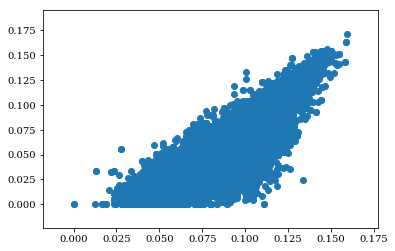

In [75]:
import matplotlib.pyplot as plt
#The next line is not needed if running outside of Jupyter Notebooks
%matplotlib inline 
plt.scatter(expected_values,observed_values)
plt.show()

 We now have a functional if not especially pretty graph of the frequency of CG dinucleotides across an entire genome. Not bad!
 
 The next few sections will discuss some common tweaks you can do to make your scatterplots and other matplotlib plots a little bit prettier. Feel free to skip them if you like.

#### Modifying the color and transparency of our scatter plot

We can adjust the color of points with the `color` parameter. We can either pass in a specific color, a list of colors for each point, or use one of matplotlib's prebuilt named colors. You can find a list of all the pre-built named colors that come with matplotlib [here](https://matplotlib.org/stable/gallery/color/named_colors.html).

We might also notice that our points are all on top of each other, so it's hard to tell how many there are in the middle of the graph. We can partially address this using the `alpha` parameter, which sets the transparency of your points:

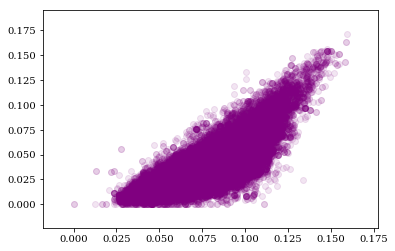

In [76]:
import matplotlib.pyplot as plt
#This line is not needed if running outside of Jupyter Notebooks
%matplotlib inline 

#Build the plot
plt.scatter(expected_values,observed_values,color='purple',alpha = 0.10)
#Show the plot
plt.show()

#### Adding x and y labels

We can add x and y labels with the `xlabel` and `ylabel` functions in `matplotlib.pyplot`:

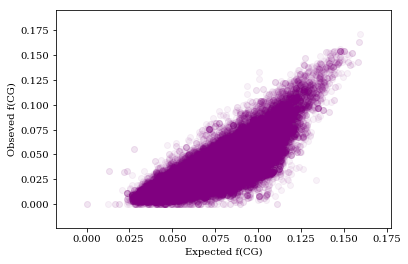

In [77]:
#Build the plot
plt.scatter(expected_values,observed_values,color='purple',alpha = 0.05)

#Add x and y labels
plt.xlabel("Expected f(CG)")
plt.ylabel("Obseved f(CG)")

#Show the plot
plt.show()

#### Adding a reference line

It's sort of hard to see whether the observed points are above or below our predictions. Let's add a reference line to our plot that reflects what we would see if our observations perfectly matched our predictions. This is equivalent to plotting a line where the y-value for each point is the same as it's x-value. We can accomplish that with the matplotlib.pyplot `plot` function. You can find additional documentation about this function [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

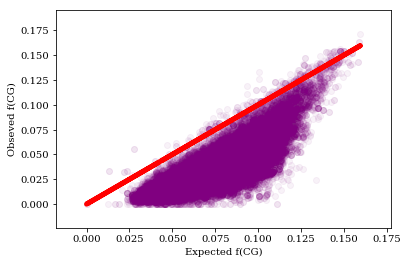

In [78]:
xs = expected_values
ys = observed_values

#Build the scatter plot
plt.scatter(xs,ys,color='purple',alpha = 0.05)

#Plot the line representing expected values
#NOTE: I did not in any way remember all these parameters, 
#I have to look it up almost every time in the reference:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(xs, xs, color = 'red',linestyle='solid',linewidth=5.0)

#Add x and y labels
plt.xlabel("Expected f(CG)")
plt.ylabel("Obseved f(CG)")

#For convenience save x and y values in xs and ys
xs = expected_values
ys = observed_values


#Show the plot
plt.show()

#### Adding colors to represent error

It might be nice if the colors of our points reflected error (typically represented as the squared difference from the red expectation line). `matplotlib` will accept a list of colors, and can translate numbers into colors using a color map of `cmap`. We just have to set up numbers that represent the amount of error in our prediction of CG content for each gene, pick a cmap (a list of cmap names can be found [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html)), and then pass our list of colors (as numbers) and our chosen color map name (as a string) into scatter. Here's how we might do this: 

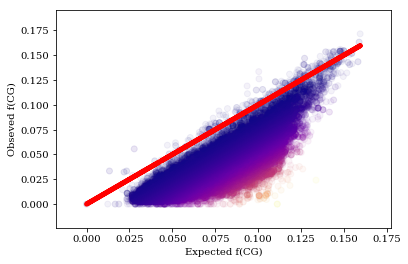

In [79]:
#Matplotlib can translate floating point numbers into colors
#Therefore we can use this to color based on the squared difference
#between our expected (x) and observed(y) values

#Behind the scenes matplotlib uses a colormap or cmap to do this
#so we can also adjust how our numbers --> colors by giving a 
#new cmap name. A list of cmaps can be found here:
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

colors = [((x - y)**2) for x,y in zip(xs,ys)]

#Build the scatter plot
plt.scatter(xs,ys,c=colors,cmap = 'plasma',alpha = 0.05)

#Plot the line representing expected values
#NOTE: I did not in any way remember all these parameters, 
#I have to look it up almost every time in the reference:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(xs, xs, color = 'red',linestyle='solid',linewidth=5.0)

#Add x and y labels
plt.xlabel("Expected f(CG)")
plt.ylabel("Obseved f(CG)")

#For convenience save x and y values in xs and ys
xs = expected_values
ys = observed_values


#Show the plot
plt.show()

#### Additional styling

This [guide](https://www.ajnisbet.com/blog/tufte-in-matplotlib) has some examples of how to style matplotlib plots following the style recommendations in Edward Tufte's 'The Visual Display of Quantitative Information'. We can adapt some of these tricks to our scatter plot. Many are minor — like turning off unnecessary tick marks on axes and making font sizes a bit bigger than the default — but together they do in my opinion make the figure look a bit better. I'd note that for this level of detail, unless you make figures in matplotlib almost daily, you will likely have to remind yourself how to adjust certain aspects of your figure. That's OK and very normal.

In any case, here's what I arrived at after some fussing and in consultation with the guide linked above:

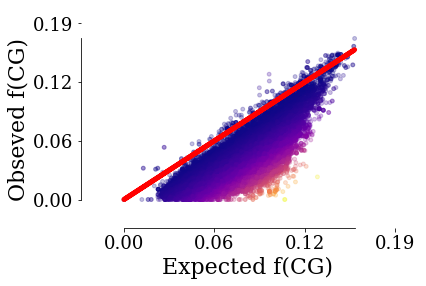

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt


xs = expected_values
ys = observed_values
N = len(expected_values)

#Matplotlib can translate floating point numbers into colors
#Therefore we can use this to color based on the squared difference
#between our expected (x) and observed(y) values

#Behind the scenes matplotlib uses a colormap or cmap to do this
#so we can also adjust how our numbers --> colors by giving a 
#new cmap name. A list of cmaps can be found here:
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

colors = [((x - y)**2) for x,y in zip(xs,ys)]
area = 15  

#Plot a line showing our expectation
plt.rcParams.update({'font.size': 22})
# Prepare the plot  
fig, ax = plt.subplots()

#Plot the scatterplot
plt.scatter(xs, ys, s=area, c=colors, cmap = 'plasma', alpha=0.25)

#Plot the line representing expected values
plt.plot(xs, xs, color = 'red',linestyle='solid',linewidth=5.0)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)

# Global options.
plt.rcParams['font.family'] = 'serif'

#Set the axes to only show two digits
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase y tick spacing.
import matplotlib.ticker as ticker

# Set where the numbers occur on the x and y axes so they
# aren't crowded.

#There are 16 dinucleotides, so maybe 1/16 is a natural
# x axis tick spacing?

n_dinucs = 16
spacing = 1.0 /n_dinucs

ax.yaxis.set_major_locator(ticker.MultipleLocator(base= spacing))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base= spacing))

#Add some extra space on each side of the axis numbers
extra_space = 0.03
max_x_or_y_value = max(max(xs),max(ys))
min_x_or_y_value = min(min(xs),min(ys))

plt.xlim(min_x_or_y_value - extra_space, max_x_or_y_value + extra_space)
plt.ylim(min_x_or_y_value - extra_space, max_x_or_y_value + extra_space)

# Adjust the range of the x and y axis lines so they match the 
# minimum and maximum
# values in the data (this is known as a 'range frame')
ax.spines['bottom'].set_bounds(min(xs), max(xs))
ax.spines['left'].set_bounds(min(ys), max(ys))


plt.xlabel("Expected f(CG)",)
plt.ylabel("Obseved f(CG)")

plt.show()

#### Save our figure

Finally, the `matplotlib.pyplot` module has a way to save our figures to a file for later reference. The `dpi` parameter can be used to control the resolution (dpi = "dots per inch")

In [81]:
plt.savefig('human_cg_content.png',dpi=300)
from os import listdir
listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 '243230.17',
 '243230.17 2',
 '9606.33',
 '9606.33 2',
 '9606.33 3',
 'Dict and List review.ipynb',
 'GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna',
 'GCF_000001405.39_GRCh38.p13_cds_from_genomic.fna.gz',
 'hello_world.py',
 'human_cg_content.png',
 'PATRIC_Export (1).zip',
 'PATRIC_Export (2).zip',
 'PATRIC_Export.zip',
 'PATRIC_Export_human.zip',
 'PATRIC_Export_human_all.zip',
 'PATRIC_genome.txt',
 'Practice with data types.ipynb',
 'procedure.txt.save',
 'testing_genomes_for_depletion_of_CG_dinucleotides.ipynb',
 'Untitled.ipynb']

<Figure size 432x288 with 0 Axes>

# Relating our Results to our Hypothesis

Now that we've gotten through the technical part of this project, let's step back and look at our figure. Based on what you see do you think that the frequency of "CG" dinucleotides that occur in human genomes can be predicted well by the independent frequencies of "C" and "G"?

**Stop and think**: write down what you think the data tells you about our original hypothesis, and why?

(You can fill in your answer here)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


OK, got an idea? If I were to answer this question, I would first look at the graph. It's pretty clear that nearly all the points fall below the red line. This means that in the vast majority of genes in the human genome, the number of *actual* CG dinucleotides we really see is much lower than the number that "should" be there if CGs were just an ordinary letter combination formed by more or less random co-occurence of C and G. Therefore, this data directly and conclusively disproves our hypothesis.

### Why are there so few CG dinucleotides?

It turns out that this phenomenon is special to "CG" dinucleotides specifically, and doesn't occur in all organisms. However, in humans and other mammals, it turns out that the C in CG dinucleotides get's modified with a methyl (-CH<sub>4</sub>) group at a higher rate than C's occuring on their own. Cytosine (C) nucleotides modified with a methyl group ("methylated cytosines") that are in a CG dinucleotide are called CpG sites. These CpG sites reduce the ability of DNA transcription to occur in nearby genes. Therefore, in the human genome there are far fewer CG dinucleotides in protein coding genes than you would expect by chance. However, GC dinucleotides occur at a normal rate within protein coding genes. You can learn more about these CpG islands [here](https://en.wikipedia.org/wiki/CpG_site)

# Exercises


1. In this notebook, we calculated CG dinucelotide content across an entire genome to test the hypothesis that CG dinucleotides occur at the rate we would expect by chance if C and G occur *independently* (in a statistical sense). Test the same hypothesis for GC dinucleotides by modifying the above code. Do you get the same result?

2. Modify the above code to calculate and plot the GC content — the frequency of G and C divided by the frequency of all nucleotides — of every gene in the human genome against the length of each gene in the human genome

